# The Zero Order Hold - Solar Sail

The Zero Order Hold (ZOH) Solar Sail trajectory leg is implemented in `pykep` in {class}`pykep.leg.zoh_ss`. Closely resembling 
{class}`pykep.leg.zoh`, illustrated in the [The Zero Order Hold trajectory leg](<./leg_zoh.ipynb>) notebook, this class allow to consider
solar sailing dynamics, characterized by a 6D state and 2D control.

Thus, it approximates a sailing strategy via a sequence of constant sail orientations (zero order hold). The leg is defined by a starting state $\mathbf x_0 = [\mathbf r_0, \mathbf v_0]$, a final state $\mathbf x_1 = [\mathbf r_1, \mathbf v_1]$ and a time grid defining the various segment lengths.

A sequence of controls $\mathbf u = [\alpha_1, \beta_1, \alpha_2, \beta_2, ...]$ define the orientation of the sail each segment.

In this tutorial we show the basic API to interface with the class {class}`pykep.leg.zoh_ss`.

We start with some imports:

In [1]:
import pykep as pk
import heyoka as hy
import numpy as np
import pygmo as pg
from copy import deepcopy

#%matplotlib ipympl
%matplotlib inline

In [2]:
# Tolerances used in the numerical integration
# Low tolerances result in higher speed (the needed tolerance depends on the orbital regime)
tol=1e-10
tol_var = 1e-6

# We instantiate ZOH Taylor integrators for Keplerian dynamics, shipped in pykep.
ta_global = pk.ta.get_zoh_ss(tol)
ta_var_global = pk.ta.get_zoh_ss_var(tol_var)

# nd units (remember that the ZOH taylor integrator is using non dimensional units expecting MU=1 and the sail flux C defined at L=1)
MU = 139348062043.343e9  # this is the MU of the ficticious ALTAIRA star (gtoc13)
L = 149597870.691e3  # this is the reference radius (1AU) where th Altaira flux is given
V = np.sqrt(MU / L)
TIME = L / V
ACC = V / TIME

# 1 - Test the zero hold solar sail leg
We compute the gradient of the mismatch constraints numerically and using the analytical ones provided by {class}`pykep.leg.zoh_ss`. We check that they are indeed the same,
and in the process we learn how to instantiate and use the class.

We need a small helper to get the numerical gradients easily:

In [3]:
# These assume some copy of the leg as they will modify it.
def compute_mismatch_constraints_n(leg_mod, state0, controls, state1, tgrid):
   leg_mod.tgrid = tgrid
   leg_mod.state0 = state0
   leg_mod.state1 = state1
   leg_mod.controls = controls
   leg_mod.state1 = state1
   return leg_mod.compute_mismatch_constraints()

We are now ready to instantiate the leg. We do so by randomly selecting the number of segments, the cut, the effective exhaust velocity, the controls and initializing the remaining quantities.

To obtain meaningful initial and final states, we compute a Lambert transfer between two Solar System planets. This choice is not essential to the method and is only meant to provide a physically plausible example.

In [30]:
# leg random data
nseg = int(np.random.uniform(4, 20))
veff = np.random.uniform(4000, 8000) * pk.G0
controls = np.random.uniform(-np.pi/2,np.pi/2, (2*nseg,))
cut = np.random.uniform(0,1)

# putting all in nd units
state0 = [1,0,0,0,1,0]
state1 = [1,0,0,0,1,0]
tgrid = np.linspace(0, 2*np.pi, nseg+1)

# Setting the integrator parameters
ta_global.pars[2] = 0.052059975027635791
ta_var_global.pars[2] = 0.052059975027635791

# Instantiate the leg
leg = pk.leg.zoh_ss(state0, controls.tolist(), state1, tgrid, cut = cut, tas = [ta_global, ta_var_global])

We now compute and store the analytical gradient.

In [31]:
grad_an_mc = leg.compute_mc_grad()

... and check with the numerically computed one. We compute the numerical gradient using `pagmo` provided routine.

In [32]:
# Check on dmc/dx0
leg_copy = deepcopy(leg)
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg_copy, x, leg_copy.controls, leg_copy.state1, leg_copy.tgrid), leg.state0).reshape(6,-1)
np.linalg.norm(grad_num-grad_an_mc[0])

3.7305009221480238e-08

In [33]:
# Chack on dmc/dxf
leg_copy = deepcopy(leg)
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg_copy, leg_copy.state0, leg_copy.controls, x, leg_copy.tgrid), leg.state1).reshape(6,-1)
np.linalg.norm(grad_num-grad_an_mc[1])

7.0848676705098539e-07

In [34]:
# Chack on dmc/dcontrols
leg_copy = deepcopy(leg)
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg_copy, leg_copy.state0, x, leg_copy.state1, leg_copy.tgrid), leg.controls, dx=1e-8).reshape(6,-1)
np.linalg.norm(grad_num-grad_an_mc[2])

6.1336666478882253e-07

In [35]:
leg_copy = deepcopy(leg)
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg_copy, leg_copy.state0, leg_copy.controls, leg_copy.state1, x), leg.tgrid).reshape(6,-1)
np.linalg.norm(grad_num-grad_an_mc[3])

9.8594583443812481e-08

So ... those are small differences, compatible with the numerical gradient low precision (the analytical gradient will be better, and can be made as accurate as needed controlling the precision of the Taylor adaptive integrator)

We can even plot the leg, in this case overlaying it with pykep planets.

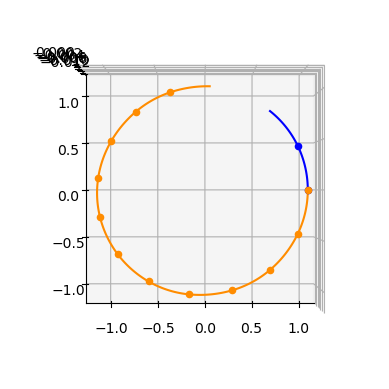

In [37]:
ax = pk.plot.make_3Daxis()
fwd, bck = leg.get_state_info(N=100)
for segment in fwd:
    ax.scatter(segment[0,0], segment[0,1], segment[0,2], c = 'blue') 
    ax.plot(segment[:,0], segment[:,1], segment[:,2], c= 'blue') 
for segment in bck:
    ax.scatter(segment[0,0], segment[0,1], segment[0,2], c = 'darkorange') 
    ax.plot(segment[:,0], segment[:,1], segment[:,2], c= 'darkorange') 

ax.view_init(90,-90)


Also in {class}`pykep.leg.zoh_ss` we can use our custom dynamics (for example equinoctial elements, or change the sail characterization), passing the corresponding integrators via the *tas* argument in the constructor.